### **Dynamic Price Optimization**

Price optimization is a strategic approach that uses data collection on sales, costs, competition, and market trends to predict demand changes and analyze price elasticity, which enables businesses to set optimal prices.
It involves competitive analysis to monitor market positioning, customer segmentation to identify varying willingness to pay, and the use of mathematical optimization algorithms to determine the best price points.

**Aim:** Develop and implement a two-stage data-driven dynamic price optimization pipeline. This pipeline aims to integrate competitive analysis and demand elasticity estimation to generate guarded, actionable price recommendations. The ultimate objective is to improve revenue and inform strategic decision-making through controlled real-world testing.

**Objectives:**
1. Conducting exploratory data analysis on price distributions, sales relationships, and weekly trends.
2. Estimating the price elasticity of demand using a log-log regression model with fixed effects.
3. Developing a dynamic pricing model that simulates quantity response within defined guardrails.
4. Segmenting products by price tiers.
5. Generating actionable recommendations.

This analysis explores pricing behaviour using historical sales data that includes:
- our prices and quantities sold
- a competitor’s price for comparable items

IMPORTANT:
This dataset does NOT include competitor quantities or competitor sales.
Any revenue calculated using competitor prices assumes OUR quantities remain the same.
Such results are hypothetical and should not be interpreted as actual competitor performance.

**Import libraries**

In [1]:
import os # Used for operating system-dependent functionality, like creating directories.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf # Library for statistical modeling, including regression analysis.

**Import dataset**

In [2]:
# Define the path to the CSV file containing the pricing data.
CSV_PATH = "Competition_Data.csv"
# Load the CSV data
pricing_data = pd.read_csv(CSV_PATH)


print("Loaded:", pricing_data.shape)
print(pricing_data.head())

Loaded: (100000, 9)
   Index Fiscal_Week_ID   Store_ID   Item_ID   Price  Item_Quantity  \
0      0        2019-11  store_459  item_526  134.49            435   
1      1        2019-11  store_459  item_526  134.49            435   
2      2        2019-11  store_459  item_526  134.49            435   
3      3        2019-11  store_459  item_526  134.49            435   
4      4        2019-11  store_459  item_526  134.49            435   

   Sales_Amount_No_Discount  Sales_Amount  Competition_Price  
0                   4716.74      11272.59             206.44  
1                   4716.74      11272.59             158.01  
2                   4716.74      11272.59             278.03  
3                   4716.74      11272.59             222.66  
4                   4716.74      11272.59             195.32  


In [3]:
pricing_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   Index                     100000 non-null  int64  
 1   Fiscal_Week_ID            100000 non-null  object 
 2   Store_ID                  100000 non-null  object 
 3   Item_ID                   100000 non-null  object 
 4   Price                     100000 non-null  float64
 5   Item_Quantity             100000 non-null  int64  
 6   Sales_Amount_No_Discount  100000 non-null  float64
 7   Sales_Amount              100000 non-null  float64
 8   Competition_Price         100000 non-null  float64
dtypes: float64(4), int64(2), object(3)
memory usage: 6.9+ MB


**Data visualisations**

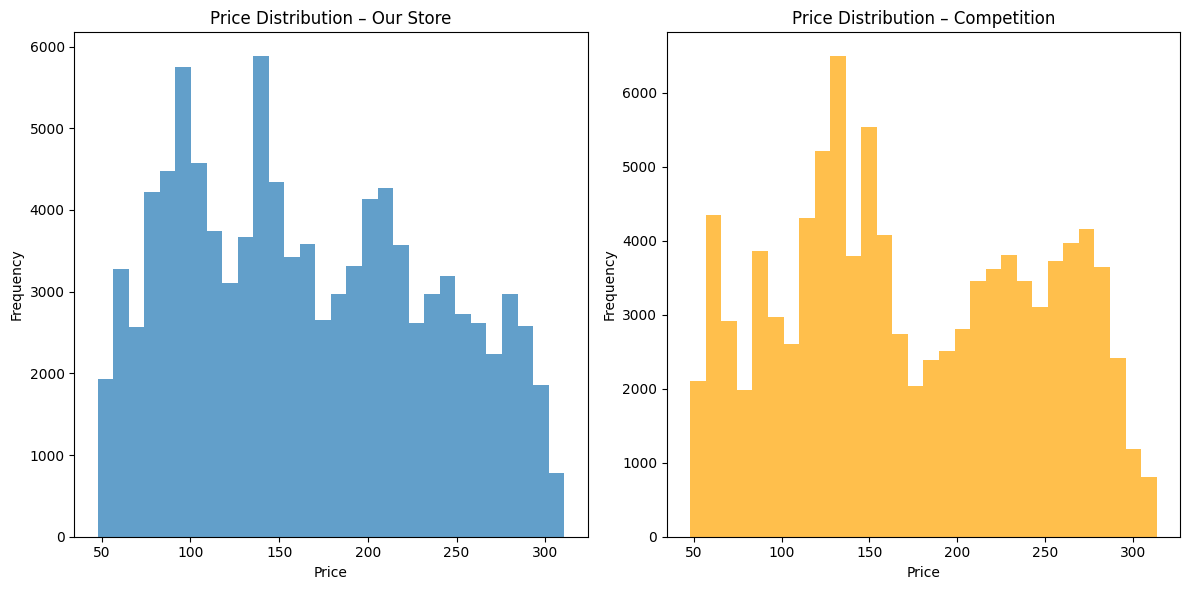

In [4]:
plt.figure(figsize=(12, 6))

# Subplot 1: Price Distribution for Our Store
plt.subplot(1, 2, 1)
plt.hist(pricing_data['Price'], bins=30, alpha=0.7) # Create a histogram of 'Price' column
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.title('Price Distribution – Our Store')

# Subplot 2: Price Distribution for Competition
plt.subplot(1, 2, 2)
plt.hist(pricing_data['Competition_Price'], bins=30, alpha=0.7, color='orange') # Create a histogram of 'Competition_Price'
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.title('Price Distribution – Competition')

plt.tight_layout() # Adjust subplot parameters for a tight layout.
plt.show()

The distributions show that competitor prices tend to be higher on average,
while our prices are more evenly spread across the available price range.
This comparison reflects pricing levels only and does not imply relative performance.

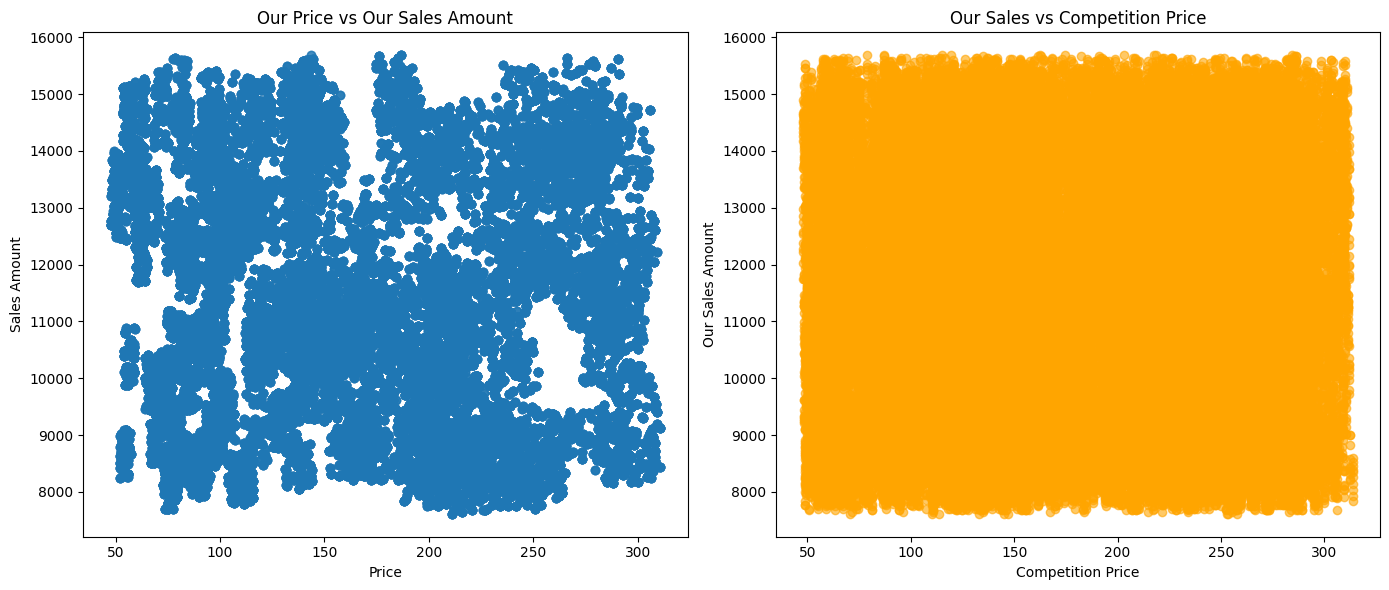

In [5]:
# Price vs sales relationships

plt.figure(figsize=(14, 6))

# Subplot 1: Our Price vs Our Sales Amount
plt.subplot(1, 2, 1)
plt.scatter(pricing_data['Price'], pricing_data['Sales_Amount'], alpha=0.6) # Create a scatter plot of 'Price' against 'Sales_Amount'
plt.xlabel('Price')
plt.ylabel('Sales Amount')
plt.title('Our Price vs Our Sales Amount')

# Subplot 2: Our Sales vs Competition Price
plt.subplot(1, 2, 2)
plt.scatter(pricing_data['Competition_Price'], pricing_data['Sales_Amount'],
            alpha=0.6, color='orange') # Create a scatter plot of 'Competition_Price' against 'Sales_Amount'
plt.xlabel('Competition Price')
plt.ylabel('Our Sales Amount')
plt.title('Our Sales vs Competition Price')

plt.tight_layout()
plt.show()

The left plot shows how our sales amounts vary across our own price points.
The right plot shows how our sales relate to competitor prices.
This does not represent competitor sales or competitor performance.
It simply shows whether our sales tend to be higher or lower when competitor prices differ.

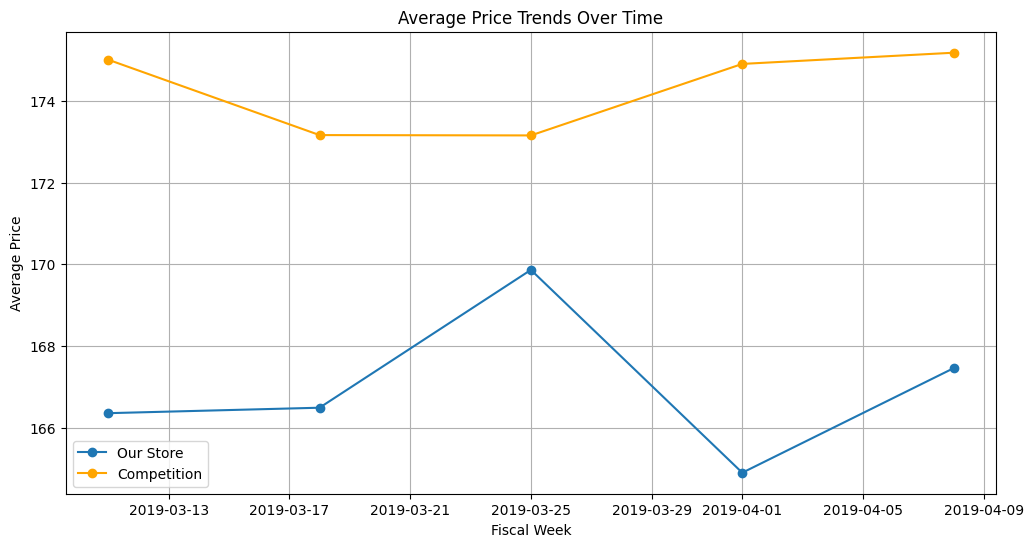

In [6]:
# Weekly price trends

df1 = pricing_data.copy()

# Fiscal weeks are parsed using the ISO week calendar (%G-%V-%u),
# which aligns with standard retail and supply-chain reporting where weeks start on Monday.
df1["Fiscal_Week_ID"] = pd.to_datetime(
    df1["Fiscal_Week_ID"] + "-1",
    format="%G-%V-%u"   # ISO year, ISO week, Monday=1
)


# Group the DataFrame by 'Fiscal_Week_ID' and calculate the mean 'Price' and 'Competition_Price'
# for each week. Then reset the index to turn the grouped 'Fiscal_Week_ID' back into a column.
weekly_prices = df1.groupby('Fiscal_Week_ID').agg({
    'Price': 'mean',
    'Competition_Price': 'mean'
}).reset_index()

plt.figure(figsize=(12, 6))
# Plot our store's average weekly prices.
plt.plot(weekly_prices['Fiscal_Week_ID'], weekly_prices['Price'],
         label='Our Store', marker='o')
# Plot the competitor's average weekly prices.
plt.plot(weekly_prices['Fiscal_Week_ID'], weekly_prices['Competition_Price'],
         label='Competition', marker='o', color='orange')

plt.xlabel('Fiscal Week')
plt.ylabel('Average Price')
plt.title('Average Price Trends Over Time')
plt.legend()
plt.grid(True)
plt.show()

Competitor prices remain consistently higher over time,
while our prices fluctuate more from week to week.

This highlights different pricing patterns,
but does not explain differences in demand or revenue on its own.

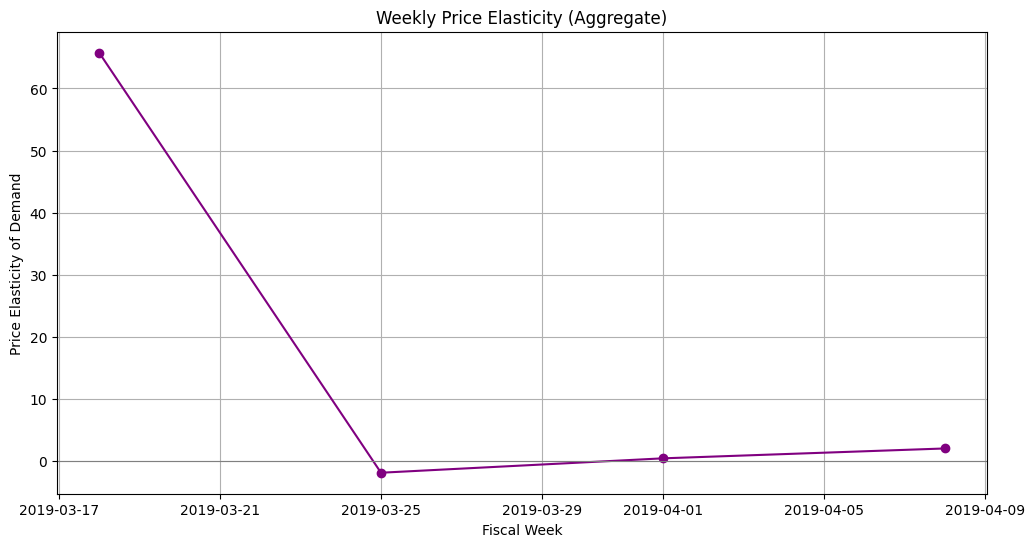

In [7]:
# Elasticity (weekly aggregate)
# Group the DataFrame by 'Fiscal_Week_ID' and calculate the mean 'Price' and sum 'Item_Quantity' for each week.
weekly_demand = df1.groupby('Fiscal_Week_ID').agg({
    'Price': 'mean',
    'Item_Quantity': 'sum'
}).reset_index()

# Calculate the percentage change in price and quantity from the previous week.
weekly_demand['price_change'] = weekly_demand['Price'].pct_change()
weekly_demand['qty_change'] = weekly_demand['Item_Quantity'].pct_change()

# Calculate elasticity as the ratio of percentage change in quantity to percentage change in price.
weekly_demand['elasticity'] = weekly_demand['qty_change'] / weekly_demand['price_change']

# Replace infinite values (which can occur if price_change is zero) with NaN and drop rows with NaN elasticity.
weekly_demand.replace([float('inf'), -float('inf')], float('nan'), inplace=True)
weekly_demand.dropna(subset=['elasticity'], inplace=True)


plt.figure(figsize=(12, 6))
# Plot the weekly elasticity with markers and a line style.
plt.plot(weekly_demand['Fiscal_Week_ID'], weekly_demand['elasticity'],
         marker='o', linestyle='-', color='purple')
# Add a horizontal line at y=0 for reference.
plt.axhline(0, color='grey', linewidth=0.8)
plt.xlabel('Fiscal Week')
plt.ylabel('Price Elasticity of Demand')
plt.title('Weekly Price Elasticity (Aggregate)')
plt.grid(True)
plt.show()

Elasticity is calculated at a weekly aggregate level,
which ensures changes in price and quantity are aligned over time. The elasticity estimates summarize how quantity typically responds to price. If elasticity is close to 0 (e.g., -0.2), demand is relatively less sensitive. More negative (e.g., -2.0) suggests stronger sensitivity to price changes.

Most elasticity values fluctuate around zero,
suggesting demand is relatively inelastic at the aggregate level.
Large swings may reflect promotions, seasonality, or product-mix changes,
not pure price effects.

In [8]:
# Hypothetical revenue comparison

# Calculate the total sales amount from our store's existing pricing.
total_sales_our_store = df1['Sales_Amount'].sum()

# Calculate a hypothetical total revenue by multiplying the competitor's price
# by our item quantities. This assumes our quantities remain the same if we were
# to charge competitor prices, which is a strong assumption.
hypothetical_revenue_comp_prices = (
    df1['Competition_Price'] * df1['Item_Quantity']
).sum()

# Create a summary DataFrame to compare the two revenue figures.
summary = pd.DataFrame({
    'Metric': ['Total Revenue'],
    'Our Pricing': [total_sales_our_store],
    'Hypothetical Revenue at Competition Prices (Same Quantities)': [
        hypothetical_revenue_comp_prices
    ]
})

print("Hypothetical Revenue Summary")
print(summary)

Hypothetical Revenue Summary
          Metric   Our Pricing  \
0  Total Revenue  1.139687e+09   

   Hypothetical Revenue at Competition Prices (Same Quantities)  
0                                       6.965710e+09             


The hypothetical revenue assumes we sold the same quantities
but charged competitor prices.

This comparison reflects price-level differences only
and does NOT imply competitor pricing is more effective in reality.

In [9]:
# Price bracket analysis (hypothetical)

# Define price bins and corresponding labels for categorization.
bins = [0, 50, 100, 150, 200, 250, 300, 350, 400, 450, 500]
labels = ['0-50', '51-100', '101-150', '151-200', '201-250',
          '251-300', '301-350', '351-400', '401-450', '451-500']

# Create a new column 'price_bracket' by categorizing 'Price' into the defined bins.
df1['price_bracket'] = pd.cut(
    df1['Price'], bins=bins, labels=labels, right=False
)

# Calculate hypothetical sales if our items were sold at competitor prices, using our quantities.
df1['hypothetical_comp_sales'] = (
    df1['Competition_Price'] * df1['Item_Quantity']
)

# Group the DataFrame by 'price_bracket' and sum up 'Sales_Amount' (our revenue)
# and 'hypothetical_comp_sales' (hypothetical competitor revenue) for each bracket.
sales_by_bracket = df1.groupby('price_bracket', observed=False).agg({
    'Sales_Amount': 'sum',
    'hypothetical_comp_sales': 'sum'
}).reset_index()

# Rename columns
sales_by_bracket.columns = [
    'Price Bracket',
    'Our Revenue',
    'Hypothetical Revenue at Competition Prices'
]


print("\nStage 1 — Revenue by Price Bracket (Hypothetical)")
print(sales_by_bracket)


Stage 1 — Revenue by Price Bracket (Hypothetical)
  Price Bracket   Our Revenue  Hypothetical Revenue at Competition Prices
0          0-50  3.050171e+06                                1.424296e+07
1        51-100  2.505968e+08                                1.534078e+09
2       101-150  2.874427e+08                                1.762144e+09
3       151-200  2.048791e+08                                1.304719e+09
4       201-250  2.104529e+08                                1.357851e+09
5       251-300  1.699713e+08                                9.234198e+08
6       301-350  1.329362e+07                                6.925566e+07
7       351-400  0.000000e+00                                0.000000e+00
8       401-450  0.000000e+00                                0.000000e+00
9       451-500  0.000000e+00                                0.000000e+00


Higher hypothetical revenue in certain brackets indicates
higher competitor prices in those ranges.

It does not indicate stronger competitor demand.


The table shows the total sales amounts for both our store and the competition across different price brackets. Here are some key observations:

- 0-50 Bracket: The competition has significantly higher sales in this bracket.

- 51-100 Bracket: The competition outperforms our store by a wide margin.
- 101-150 Bracket: The competition’s sales are much higher than our store’s sales.
- 151-200 Bracket: The competition again has significantly higher sales.
- 201-250 Bracket: The competition’s sales are nearly double those of our store.
- 251-300 Bracket: The competition has higher sales, but the gap is smaller compared to other brackets.
301-350 Bracket: The competition has higher sales, though the overall sales amount is lower in this bracket compared to others.

**Price Optimization with Dynamic Pricing**

In [10]:
# Product (item) segmentation
# This section groups individual items into price tiers based on their average price.

# Calculate the mean price and total quantity for each unique Item_ID.
item_summary = df1.groupby('Item_ID').agg({
    'Price': 'mean',
    'Item_Quantity': 'sum'
}).reset_index()

# Merge summary back into the main df1 to add the average price per item.
df1 = df1.merge(
    item_summary, on='Item_ID', suffixes=('', '_avg')
)

# Create a new column 'segment' by categorizing items into 'Low', 'Medium', or 'High' price tiers.
df1['segment'] = pd.cut(
    df1['Price_avg'],
    bins=[0, 50, 150, 300],
    labels=['Low', 'Medium', 'High']
)

This segmentation groups PRODUCTS by average price.
It is not customer segmentation.

In [11]:
# Dynamic pricing (price-only simulation)
dynamic_pricing_data = df1.copy()

# Apply dynamic pricing rules: increase price by 5% for 'Medium' segment,
# and decrease price by 10% for 'High' segment. 'Low' segment prices remain unchanged.
dynamic_pricing_data.loc[
    dynamic_pricing_data['segment'] == 'Medium',
    'dynamic_price'
] = dynamic_pricing_data['Price'] * 1.05

dynamic_pricing_data.loc[
    dynamic_pricing_data['segment'] == 'High',
    'dynamic_price'
] = dynamic_pricing_data['Price'] * 0.90

# For items not in 'Medium' or 'High' (i.e., 'Low' segment), their dynamic price is their original price.
# This also handles any rows where 'segment' might be NaN or not matched.
dynamic_pricing_data['dynamic_price'] = dynamic_pricing_data['dynamic_price'].fillna(dynamic_pricing_data['Price'])

# Calculate the dynamic sales amount assuming Item_Quantity remains constant despite price changes.
dynamic_pricing_data['dynamic_sales_amt'] = (
    dynamic_pricing_data['dynamic_price'] *
    dynamic_pricing_data['Item_Quantity']
)

# Create a summary DataFrame to compare existing pricing revenue and quantity
# with the dynamic pricing scenario's revenue (keeping quantity constant).
comparison_summary = pd.DataFrame({
    'Metric': ['Total Revenue', 'Total Quantity'],
    'Existing Pricing': [
        df1['Sales_Amount'].sum(),
        df1['Item_Quantity'].sum()
    ],
    'Dynamic Pricing (Quantity Held Constant)': [
        dynamic_pricing_data['dynamic_sales_amt'].sum(),
        df1['Item_Quantity'].sum()
    ]
})

print("Price-only Dynamic Pricing Comparison")
print(comparison_summary)

Price-only Dynamic Pricing Comparison
           Metric  Existing Pricing  Dynamic Pricing (Quantity Held Constant)
0   Total Revenue      1.139687e+09                              6.249350e+09
1  Total Quantity      3.996113e+07                              3.996113e+07


Under this price-only simulation,
revenue increases IF quantity sold remains unchanged.

This is not a demand-aware model.
In practice, quantity may change when prices change,
so these results should be interpreted cautiously. We are simulating the impact of a dynamic pricing strategy on sales performance. First, we created a copy of the dataset for the simulation. We then applied dynamic pricing rules by increasing prices by 5% for the Medium segment and decreasing prices by 10% for the High segment. Then, we calculated new sales amounts based on these dynamic prices. Next, we compared the total sales amount and total quantity sold under the existing pricing and the dynamic pricing strategies.

In [12]:
# add dynamic prices to original dataset
df1['dynamic_price_stage1'] = dynamic_pricing_data['dynamic_price']

**Summary**

This analysis looked at how our pricing compares to competitors and how price relates to sales performance over time. The goal was not to predict exact outcomes, but to understand pricing patterns, risks, and opportunities using the data available.

Key Takeaways:

1. We are consistently priced lower than competitors

Across most weeks, our prices are lower than competitor prices. This pattern is stable over time, suggesting a deliberate pricing position rather than short-term discounting. It indicates that we compete on price, but it does not on its own explain how customers respond to those prices.

2. Sales revenue is driven more by how much we sell than by price alone

Sales revenue changes much more with the number of items sold than with price changes. Even when prices are similar, revenue can vary widely depending on demand. This shows that pricing decisions cannot be evaluated without considering how customers react.

3. Customer response to price changes is mixed

When looking at the data as a whole, demand does not consistently rise or fall with price changes. This does not mean customers are insensitive to price, but rather that different products behave differently, and those differences cancel out when everything is grouped together.

4. Competitor prices provide context, not performance signals

Competitor prices help explain the market environment we operate in, but they do not tell us how well competitors are performing. The analysis only shows how our sales behave when competitor prices are higher or lower — it does not measure competitor demand or success.

5. There may be room to increase prices, but only with caution

When we simulate charging competitor prices while keeping sales volumes the same, revenue increases. However, this scenario assumes customers would buy the same amount at higher prices, which may not be true. This highlights potential pricing headroom, but also the risk of losing sales if prices rise too far.

6. Pricing risk is not the same across all products

Some price ranges appear more sensitive to price assumptions than others. This suggests that price changes should not be applied uniformly. Certain products may be safer to test price increases on, while others may require more caution.

7. Grouping products by price helps guide pricing decisions

By grouping products into low-, medium-, and high-price categories, we can think about different pricing strategies for different types of products, instead of using a single approach for everything.

8. Simple price changes are not enough on their own

The final pricing simulation shows that revenue outcomes depend heavily on whether sales volumes change. This reinforces an important takeaway: price changes should always be evaluated alongside customer demand, not in isolation.


This analysis shows that pricing decisions are closely tied to customer demand and product differences. While competitor prices provide useful context, successful pricing requires understanding how customers respond, not just how prices compare. The results support using careful testing, product-specific strategies, and demand-aware models when making pricing decisions, rather than relying on simple price adjustments alone.

### **Improved pipeline**

Stage 2 improves the analysis in four ways:
1) Panelize the dataset to avoid duplicated rows (week-store-item).
   The raw dataset can contain multiple rows per week/store/item due to
   competitor price records. If we don’t dedupe, our own quantity/sales
   can be accidentally double-counted.
2) EDA (Exploratory Data Analysis) using the cleaned panel.
  We look at price distributions, price gaps vs competitor, and weekly trends.

3) Estimate demand sensitivity (“price elasticity”) using a log–log regression
with fixed effects (item, store, week). This is more defensible than
row-to-row pct_change because it aligns price and quantity over time.

4) Dynamic pricing that models quantity response.
Instead of assuming quantity stays constant, we use the elasticity estimate
to simulate how quantity would change with price adjustments.

All Stage 2 charts are displayed AND saved into outputs_price_optimization/.

In [13]:
OUT_DIR = "outputs_price_optimization"
os.makedirs(OUT_DIR, exist_ok=True)

SHOW_PLOTS = True

MIN_OBS_PER_ITEM = 30 # Minimum number of observations required for an item to have its own elasticity estimated.
MIN_UNIQUE_PRICES_PER_ITEM = 4 # Minimum number of unique prices required for an item to have its own elasticity estimated.

# Guardrails - these define constraints for the dynamic pricing recommendations
ELAST_CAP_MIN = -5.0 # Lower bound for elasticity values, preventing overly aggressive demand responses.
ELAST_CAP_MAX = -0.05 # Upper bound for elasticity values (closer to 0 implies less elastic demand), preventing unrealistic positive elasticities or very low negative ones.
PRICE_BAND_AROUND_CURRENT = 0.20 # Maximum allowed percentage change (up or down) from the current price.
COMP_BAND_LOW = 0.70 # Lower bound for recommended price relative to competitor's price (e.g., recommended price should be at least 70% of competitor's).
COMP_BAND_HIGH = 1.10 # Upper bound for recommended price relative to competitor's price (e.g., recommended price should be at most 110% of competitor's).
GRID_POINTS = 21 # Number of discrete price points to evaluate within the defined guardrails during optimization.

**Helper functions**

In [14]:
def savefig(name: str):
    """Display (optional) and save the current figure."""
    if SHOW_PLOTS:
        plt.tight_layout()
        plt.show()
    path = os.path.join(OUT_DIR, name)
    plt.tight_layout()
    plt.savefig(path, dpi=160)
    plt.close()
    print(f"Saved plot: {path}")


def parse_iso_year_week_to_date(fiscal_week_id: pd.Series) -> pd.Series:
    """Convert 'YYYY-WW' to ISO week Monday date."""
    s = fiscal_week_id.astype(str)
    parts = s.str.split("-", expand=True)
    year = pd.to_numeric(parts[0], errors="coerce")
    week = pd.to_numeric(parts[1], errors="coerce")
    return pd.to_datetime(
        year.astype("Int64").astype(str) + "-W" + week.astype("Int64").astype(str).str.zfill(2) + "-1",
        format="%G-W%V-%u",
        errors="coerce",
    )


def winsorize_series(x: pd.Series, p_low=0.01, p_high=0.99) -> pd.Series:
    """Winsorize a pandas Series by capping outliers at specified percentiles."""
    lo = x.quantile(p_low)
    hi = x.quantile(p_high)
    return x.clip(lo, hi)


def safe_log(x: pd.Series) -> pd.Series:
    """Calculate the natural logarithm of a Series, handling non-positive values by replacing them with NaN."""
    return np.log(x.where(x > 0))

**Clean data**

- Converts key numeric fields to numbers
- Collapses multiple rows into one per (Fiscal_Week_ID, Store_ID, Item_ID)
by keeping our own metrics once and averaging Competition_Price.

- Prevents inflating our quantities/sales when the raw file has repeated rows
for different competitor price observations.

In [15]:
df2 = pricing_data.copy()

# Convert specified columns to numeric, coercing errors to NaN.
# This ensures that numerical operations can be performed correctly.
for col in ["Price", "Item_Quantity", "Sales_Amount", "Competition_Price"]:
    df2[col] = pd.to_numeric(df2[col], errors="coerce")

# Panelize the dataset: Group by Fiscal_Week_ID, Store_ID, and Item_ID to create unique time-series entries
# for each item in each store per week. This handles cases where raw data might have multiple
# competitor price observations for the same week-store-item combination.
# - 'Price', 'Item_Quantity', 'Sales_Amount' are taken as the 'first' observed value
#   since these are our store's metrics and should be unique for a given week-store-item.
# - 'Competition_Price' is 'mean'-aggregated to average out multiple competitor price records.
pane_temp = (
    df2.sort_values([c for c in ["Index"] if c in df2.columns] + ["Fiscal_Week_ID", "Store_ID", "Item_ID"])
       .groupby(["Fiscal_Week_ID", "Store_ID", "Item_ID"], as_index=False)
       .agg(
           Price=("Price", "first"),
           Item_Quantity=("Item_Quantity", "first"),
           Sales_Amount=("Sales_Amount", "first"),
           Competition_Price=("Competition_Price", "mean"),
       )
)

# Convert 'Fiscal_Week_ID' to a proper datetime 'week_date' for time-series analysis.
# Drop rows where 'week_date' could not be parsed (NaT).
pane_temp["week_date"] = parse_iso_year_week_to_date(pane_temp["Fiscal_Week_ID"])
panel = pane_temp.dropna(subset=["week_date"]).copy()

# Filter out rows with non-positive values for Price, Item_Quantity, or Competition_Price,
# as these would be problematic for log transformations and meaningful analysis.
panel = panel[(panel["Price"] > 0) & (panel["Item_Quantity"] > 0) & (panel["Competition_Price"] > 0)].copy()

# Calculate 'calc_sales' (Price * Item_Quantity) and 'sales_ratio' (Sales_Amount / calc_sales).
# 'sales_ratio' can help identify discrepancies between recorded Sales_Amount and calculated sales.
panel["calc_sales"] = panel["Price"] * panel["Item_Quantity"]
panel["sales_ratio"] = panel["Sales_Amount"] / panel["calc_sales"]

# Print the shape of the cleaned panel and the number of unique weeks, stores, and items.
print("Stage 2 panel shape:", panel.shape)
print("Unique weeks:", panel["Fiscal_Week_ID"].nunique(),
      "Unique stores:", panel["Store_ID"].nunique(),
      "Unique items:", panel["Item_ID"].nunique())

Stage 2 panel shape: (8800, 10)
Unique weeks: 5 Unique stores: 10 Unique items: 176


**EDA summaries**

- Creates price gap features vs competitor:
comp_gap_pct = (our_price / competitor_price) - 1

How to interpret:
- Negative comp_gap_pct → we are priced below competitor
- Positive comp_gap_pct → we are priced above competitor
- This is market positioning context, not competitor performance.

In [16]:
summary2 = panel[["Price", "Item_Quantity", "Sales_Amount", "Competition_Price", "calc_sales", "sales_ratio"]].describe().T
summary2.to_csv(os.path.join(OUT_DIR, "summary_stats.csv"))
print("Saved:", os.path.join(OUT_DIR, "summary_stats.csv"))

# Calculate absolute price gap: Our Price - Competitor Price
panel["comp_gap_abs"] = panel["Price"] - panel["Competition_Price"]
# Calculate percentage price gap: (Our Price / Competitor Price) - 1
panel["comp_gap_pct"] = (panel["Price"] / panel["Competition_Price"]) - 1
# Winsorize the percentage price gap to handle extreme outliers for better visualization and analysis.
panel["comp_gap_pct_w"] = winsorize_series(panel["comp_gap_pct"])

Saved: outputs_price_optimization/summary_stats.csv


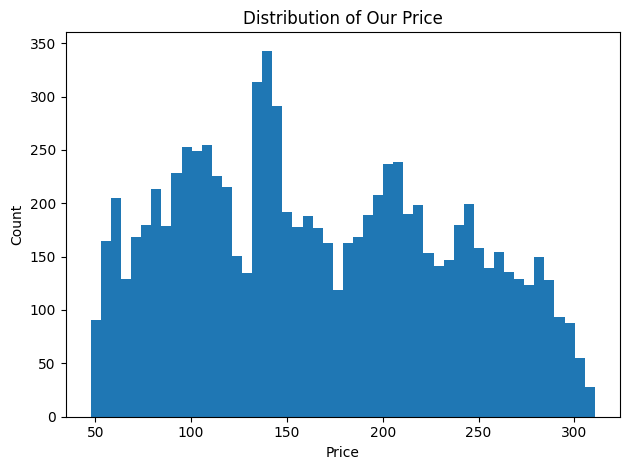

Saved plot: outputs_price_optimization/01_price_distribution.png


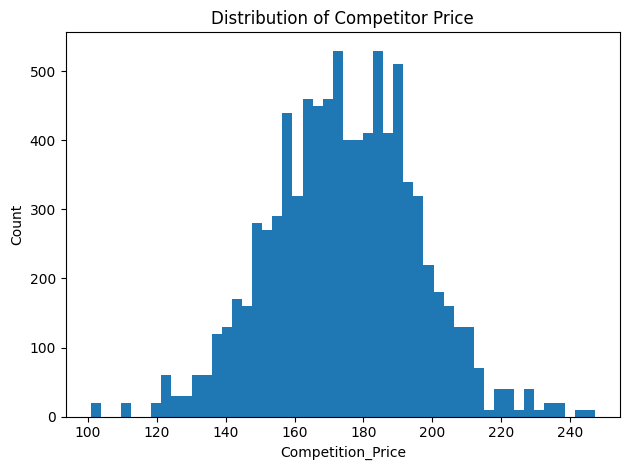

Saved plot: outputs_price_optimization/02_competitor_price_distribution.png


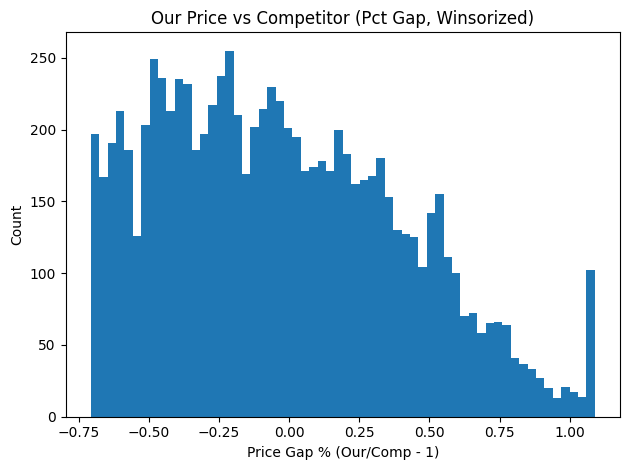

Saved plot: outputs_price_optimization/03_price_gap_pct_distribution.png


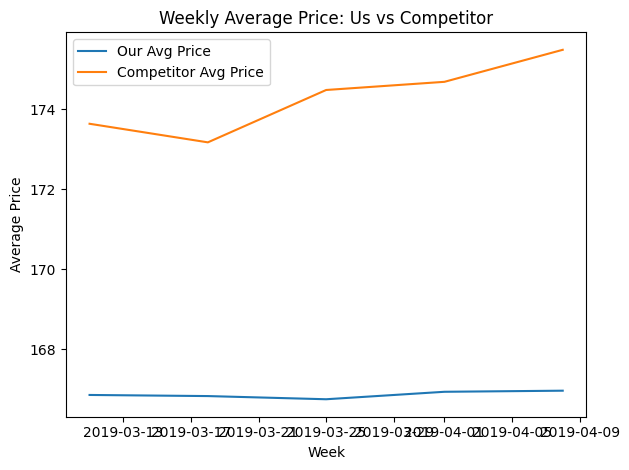

Saved plot: outputs_price_optimization/04_weekly_avg_price_us_vs_comp.png


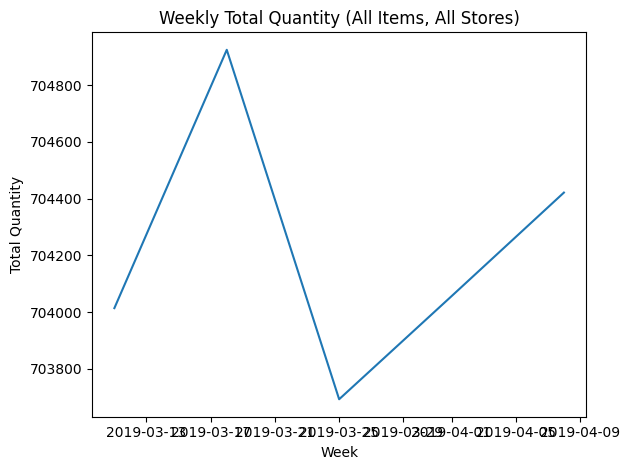

Saved plot: outputs_price_optimization/05_weekly_total_quantity.png


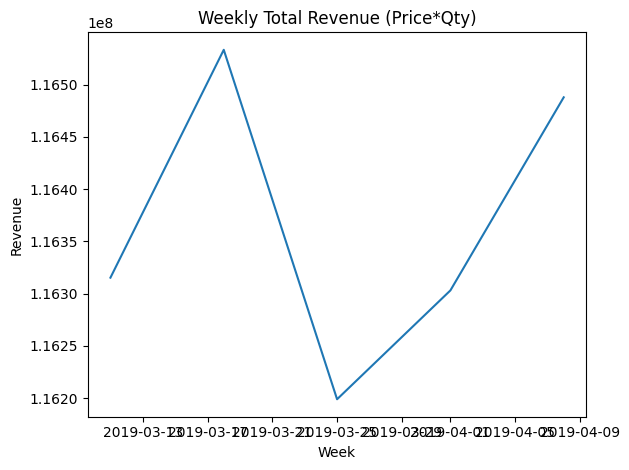

Saved plot: outputs_price_optimization/06_weekly_total_revenue.png


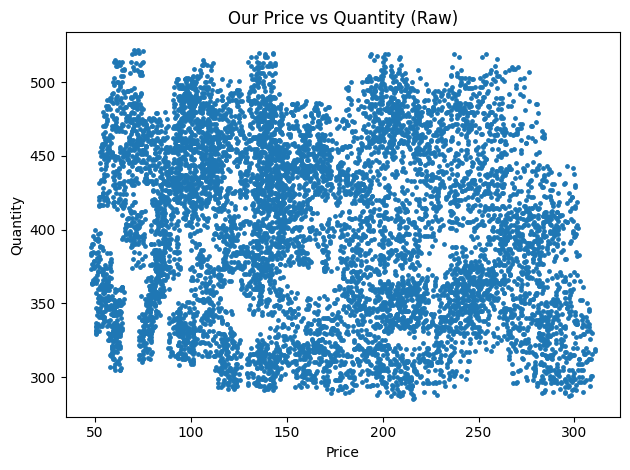

Saved plot: outputs_price_optimization/07_scatter_price_vs_qty_raw.png


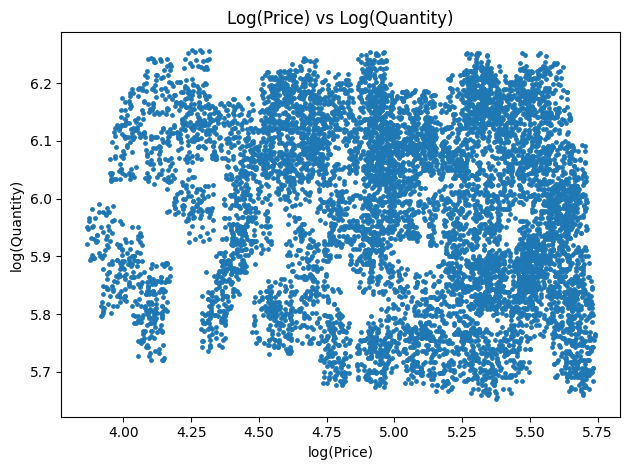

Saved plot: outputs_price_optimization/08_scatter_log_price_vs_log_qty.png


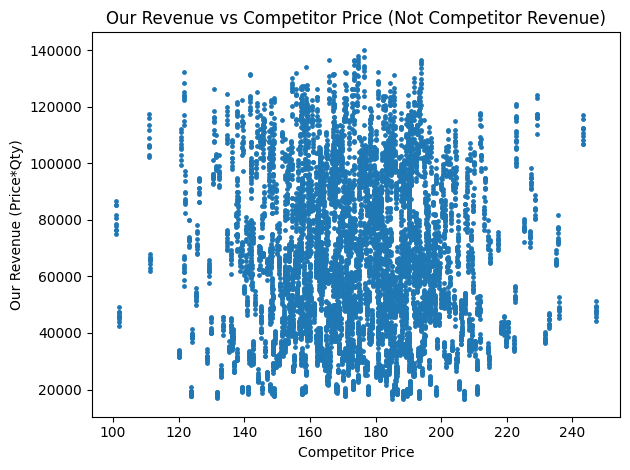

Saved plot: outputs_price_optimization/09_scatter_our_revenue_vs_comp_price.png


In [17]:
plt.figure()
plt.hist(panel["Price"], bins=50)
plt.title("Distribution of Our Price")
plt.xlabel("Price")
plt.ylabel("Count")
savefig("01_price_distribution.png")

plt.figure()
plt.hist(panel["Competition_Price"], bins=50)
plt.title("Distribution of Competitor Price")
plt.xlabel("Competition_Price")
plt.ylabel("Count")
savefig("02_competitor_price_distribution.png")

plt.figure()
plt.hist(panel["comp_gap_pct_w"], bins=60)
plt.title("Our Price vs Competitor (Pct Gap, Winsorized)")
plt.xlabel("Price Gap % (Our/Comp - 1)")
plt.ylabel("Count")
savefig("03_price_gap_pct_distribution.png")

weekly2 = (
    panel.groupby("week_date", as_index=False)
         .agg(
             avg_price=("Price", "mean"),
             avg_comp_price=("Competition_Price", "mean"),
             total_qty=("Item_Quantity", "sum"),
             total_sales=("calc_sales", "sum"),
         )
    .sort_values("week_date")
)

plt.figure()
plt.plot(weekly2["week_date"], weekly2["avg_price"], label="Our Avg Price")
plt.plot(weekly2["week_date"], weekly2["avg_comp_price"], label="Competitor Avg Price")
plt.title("Weekly Average Price: Us vs Competitor")
plt.xlabel("Week")
plt.ylabel("Average Price")
plt.legend()
savefig("04_weekly_avg_price_us_vs_comp.png")

plt.figure()
plt.plot(weekly2["week_date"], weekly2["total_qty"])
plt.title("Weekly Total Quantity (All Items, All Stores)")
plt.xlabel("Week")
plt.ylabel("Total Quantity")
savefig("05_weekly_total_quantity.png")

plt.figure()
plt.plot(weekly2["week_date"], weekly2["total_sales"])
plt.title("Weekly Total Revenue (Price*Qty)")
plt.xlabel("Week")
plt.ylabel("Revenue")
savefig("06_weekly_total_revenue.png")

plt.figure()
plt.scatter(panel["Price"], panel["Item_Quantity"], s=6)
plt.title("Our Price vs Quantity (Raw)")
plt.xlabel("Price")
plt.ylabel("Quantity")
savefig("07_scatter_price_vs_qty_raw.png")

plt.figure()
plt.scatter(np.log(panel["Price"]), np.log(panel["Item_Quantity"]), s=6)
plt.title("Log(Price) vs Log(Quantity)")
plt.xlabel("log(Price)")
plt.ylabel("log(Quantity)")
savefig("08_scatter_log_price_vs_log_qty.png")

plt.figure()
plt.scatter(panel["Competition_Price"], panel["calc_sales"], s=6)
plt.title("Our Revenue vs Competitor Price (Not Competitor Revenue)")
plt.xlabel("Competitor Price")
plt.ylabel("Our Revenue (Price*Qty)")
savefig("09_scatter_our_revenue_vs_comp_price.png")

1. Distribution of Our Price (01_price_distribution.png) This histogram shows the frequency of different price points for our products. It helps understand the general pricing strategy and common price ranges.

2. Distribution of Competitor Price (02_competitor_price_distribution.png) This plot illustrates the frequency of competitor price points, providing insight into their pricing strategies.

3. Our Price vs Competitor (Pct Gap, Winsorized) (03_price_gap_pct_distribution.png) This histogram displays the percentage difference between our price and competitor prices. A negative value means our price is lower than the competitor's, and a positive value means it's higher. Winsorization is applied to handle extreme outliers, giving a clearer view of typical price gaps.

4. Weekly Average Price: Us vs Competitor (04_weekly_avg_price_us_vs_comp.png) This line plot tracks the average prices of our products and competitors over time (weekly). It highlights trends and whether our pricing generally aligns with or deviates from the competition.

5. Weekly Total Quantity (All Items, All Stores) (05_weekly_total_quantity.png) This plot shows the total quantity of items sold each week across all items and stores, indicating overall demand trends.

6. Weekly Total Revenue (Price*Qty) (06_weekly_total_revenue.png) This plot illustrates the total revenue generated each week, reflecting the combined impact of pricing and quantity sold.

7. Our Price vs Quantity (Raw) (07_scatter_price_vs_qty_raw.png) This scatter plot shows the relationship between our product prices and the corresponding quantities sold. It gives a raw visual indication of how quantity might change with price.

8. Log(Price) vs Log(Quantity) (08_scatter_log_price_vs_log_qty.png) By plotting the logarithm of price against the logarithm of quantity, this scatter plot helps visualize the relationship in a way that can be used to estimate price elasticity more effectively, especially in regression models.

9. Our Revenue vs Competitor Price (Not Competitor Revenue) (09_scatter_our_revenue_vs_comp_price.png) This scatter plot shows how our revenue varies with competitor prices. This does not represent competitor's actual revenue or performance, but rather how our sales are influenced by their pricing actions.

**Elasticity estimation**

Estimate how quantity changes when our price changes (demand sensitivity):

Model (log–log):
log(Q) = b1*log(P) + b2*log(P_comp) + item FE + store FE + week FE

 Interpretation:
- b1 (log_p coefficient) ≈ price elasticity of demand.
  Typically negative: price ↑ → quantity ↓.
- b2 captures how competitor price relates to our quantity (context).

Why fixed effects (FE):
- item FE controls for differences between products
 - store FE controls for store-level differences
 - week FE controls for time effects (seasonality, events)

We use a constant-elasticity assumption within the tested price range, which works as a practical approximation but may not hold for very large price changes.

In [18]:
panel["log_q"] = safe_log(panel["Item_Quantity"])
panel["log_p"] = safe_log(panel["Price"])
panel["log_comp_p"] = safe_log(panel["Competition_Price"])
panel["week_id"] = panel["Fiscal_Week_ID"].astype(str)

reg = panel.dropna(subset=["log_q", "log_p", "log_comp_p"]).copy()

pooled = smf.ols(
    "log_q ~ log_p + log_comp_p + C(Item_ID) + C(Store_ID) + C(week_id)",
    data=reg
).fit()

pooled_elasticity = float(pooled.params["log_p"])
comp_cross_effect = float(pooled.params.get("log_comp_p", np.nan))

print("\nStage 2 elasticity model:")
print("  Our price elasticity (log_p):", pooled_elasticity)
print("  Competitor cross-effect (log_comp_p):", comp_cross_effect)

with open(os.path.join(OUT_DIR, "pooled_elasticity_model_summary.txt"), "w", encoding="utf-8") as f:
    f.write(pooled.summary().as_text())


Stage 2 elasticity model:
  Our price elasticity (log_p): 0.007700059437745599
  Competitor cross-effect (log_comp_p): 0.00040600800817217064


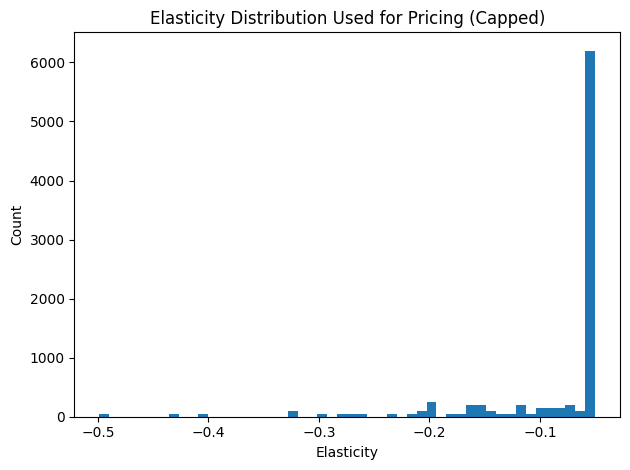

Saved plot: outputs_price_optimization/10_elasticity_distribution.png


/tmp/ipython-input-2861767993.py:43: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  panel.groupby("price_tier", as_index=False)


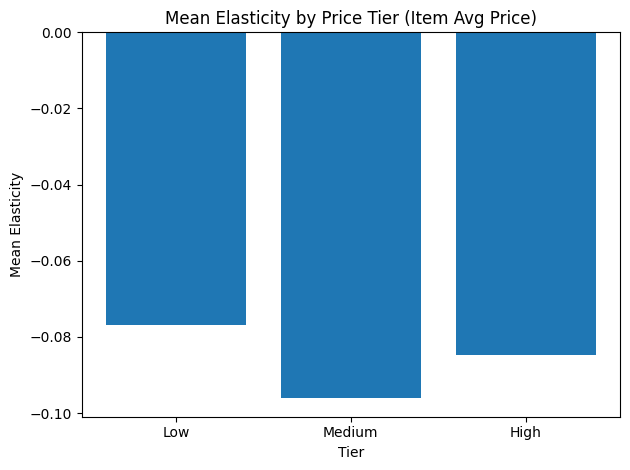

Saved plot: outputs_price_optimization/11_mean_elasticity_by_tier.png


In [19]:
item_elast = {} # Initialize an empty dictionary to store item-specific elasticity estimates.
for item_id, g in reg.groupby("Item_ID"):
    # Only estimate elasticity if an item has enough observations and unique price points.
    if len(g) < MIN_OBS_PER_ITEM or g["Price"].nunique() < MIN_UNIQUE_PRICES_PER_ITEM:
        continue
    try:
        # Fit an OLS regression model for each item to estimate its price elasticity.
        # 'log_q ~ log_p + log_comp_p + C(week_id)' models log(quantity) as a function of
        # log(our price), log(competitor price), and week fixed effects.
        m = smf.ols("log_q ~ log_p + log_comp_p + C(week_id)", data=g).fit()
        e = float(m.params.get("log_p", np.nan)) # Extract the coefficient for log_p (elasticity).
        if np.isfinite(e): # Ensure the elasticity estimate is a finite number.
            item_elast[item_id] = e # Store the item-specific elasticity.
    except Exception: # Catch any errors during model fitting for an item.
        continue

def choose_elasticity(item_id) -> float:
    """Choose an elasticity value for an item, defaulting to pooled elasticity if item-specific is not available or invalid, and applying caps."""
    e = item_elast.get(item_id, pooled_elasticity) # Get item-specific elasticity, or default to pooled.
    if not np.isfinite(e):
        e = pooled_elasticity # If still not finite, use the pooled elasticity.
    e = min(e, ELAST_CAP_MAX) # Cap the elasticity at the maximum allowed value.
    e = max(e, ELAST_CAP_MIN) # Cap the elasticity at the minimum allowed value.
    return float(e)

panel["elasticity"] = panel["Item_ID"].map(choose_elasticity) # Apply the chosen elasticity to each item in the panel DataFrame.

plt.figure() # Create a new figure for the histogram.
plt.hist(panel["elasticity"], bins=50) # Plot a histogram of the capped elasticity values.
plt.title("Elasticity Distribution Used for Pricing (Capped)")
plt.xlabel("Elasticity")
plt.ylabel("Count")
savefig("10_elasticity_distribution.png")

# Calculate the average price for each item to define price tiers.
item_price_avg = panel.groupby("Item_ID", as_index=False)["Price"].mean().rename(columns={"Price": "item_avg_price"})
panel = panel.merge(item_price_avg, on="Item_ID", how="left") # Merge average item prices back into the main panel.
# Categorize items into 'Low', 'Medium', and 'High' price tiers based on their average price quantiles.
panel["price_tier"] = pd.qcut(panel["item_avg_price"], q=3, labels=["Low", "Medium", "High"])

# Calculate mean and median elasticity, number of observations, and mean price/quantity for each price tier.
tier_stats = (
    panel.groupby("price_tier", as_index=False)
         .agg(
             mean_elasticity=("elasticity", "mean"),
             median_elasticity=("elasticity", "median"),
             n=("elasticity", "size"),
             mean_price=("Price", "mean"),
             mean_qty=("Item_Quantity", "mean"),
         )
)
tier_stats.to_csv(os.path.join(OUT_DIR, "tier_elasticity_summary.csv"), index=False) # Save the tier statistics to a CSV file.

plt.figure()
plt.bar(tier_stats["price_tier"].astype(str), tier_stats["mean_elasticity"]) # Create a bar chart of mean elasticity by price tier.
plt.title("Mean Elasticity by Price Tier (Item Avg Price)")
plt.xlabel("Tier")
plt.ylabel("Mean Elasticity")
savefig("11_mean_elasticity_by_tier.png")

This histogram illustrates the spread of the price elasticity values that will be used in our dynamic pricing model. The elasticities are derived from either individual item regressions or a pooled model, and importantly, they have been *capped* between -5.0 and -0.05. This capping is crucial to prevent extreme or unrealistic elasticity values from distorting our pricing recommendations. The distribution being heavily skewed towards negative values (as expected) confirms that as price increases, demand generally decreases. The concentration of values near the cap of -0.05 suggests that many items are considered relatively inelastic, meaning their demand isn't highly sensitive to small price changes within the observed range.

**Dynamic pricing (modeled quantity response)**

Stage 1 assumed quantity stays constant. Here we model demand response.

For each row, we test candidate prices within guardrails and use a constant-elasticity demand model:
Q_new = Q0 * (P_new / P0) ^ elasticity
Revenue_new = P_new * Q_new

We select the candidate price that maximizes modeled revenue.

Guardrails keep recommendations realistic:
- price stays within +/-20% of current
- price is anchored to a competitor band (70% to 110% of competitor price)

In [20]:
def optimize_price_row(row):
    p0 = float(row["Price"])
    q0 = float(row["Item_Quantity"])
    comp = float(row["Competition_Price"])
    e = float(row["elasticity"])

    # Define the lower and upper bounds for candidate prices, incorporating both absolute
    # percentage change from current price and competitor price bands (guardrails).
    lower = max((1 - PRICE_BAND_AROUND_CURRENT) * p0, COMP_BAND_LOW * comp)
    upper = min((1 + PRICE_BAND_AROUND_CURRENT) * p0, COMP_BAND_HIGH * comp)

    # If calculated bounds are invalid (e.g., lower >= upper due to data issues or very tight constraints),
    # default to simpler bounds around the current price.
    if not np.isfinite(lower) or not np.isfinite(upper) or lower >= upper:
        lower = (1 - PRICE_BAND_AROUND_CURRENT) * p0
        upper = (1 + PRICE_BAND_AROUND_CURRENT) * p0

    # Generate a set of candidate prices within the defined bounds.
    candidates = np.linspace(lower, upper, GRID_POINTS)

    # Model the new quantity using the constant-elasticity demand formula:
    # Q_new = Q0 * (P_new / P0) ^ elasticity
    q_new = q0 * (candidates / p0) ** e
    # Apply a safety cap to modeled quantities to prevent unrealistic increases (e.g., more than 5x original).
    q_new = np.clip(q_new, 0, q0 * 5)  # extra safety cap

    # Calculate the modeled revenue for each candidate price.
    rev_new = candidates * q_new
    # Find the index of the candidate price that maximizes the modeled revenue.
    best = int(np.argmax(rev_new))

    # Return a Series containing the optimized price, quantity, revenue, and the bounds used.
    return pd.Series({
        "dyn_price": candidates[best],
        "dyn_qty": q_new[best],
        "dyn_revenue": rev_new[best],
        "price_lower": lower,
        "price_upper": upper,
    })

# Add base_revenue to the panel DataFrame using calc_sales (Price * Item_Quantity).
panel["base_revenue"] = panel["calc_sales"]

# Apply the optimization function row-wise to the panel DataFrame to get dynamic pricing recommendations.
dyn = panel.apply(optimize_price_row, axis=1)
# Concatenate the original panel with the dynamic pricing results.
result = pd.concat([panel, dyn], axis=1)

# Calculate overall base revenue, dynamic revenue, and the estimated uplift.
base_total = float(result["base_revenue"].sum())
dyn_total = float(result["dyn_revenue"].sum())
uplift = (dyn_total / base_total) - 1 if base_total > 0 else np.nan

print("\nStage 2 — Dynamic pricing results (modeled)")
print(f"  Base revenue (Price*Qty): {base_total:,.2f}")
print(f"  Dynamic revenue (modeled): {dyn_total:,.2f}")
print(f"  Estimated uplift: {uplift:.2%}")

# Calculate percentage changes for price, quantity, and revenue due to dynamic pricing.
result["price_change_pct"] = (result["dyn_price"] / result["Price"]) - 1
result["qty_change_pct"] = (result["dyn_qty"] / result["Item_Quantity"]) - 1
result["rev_change_pct"] = (result["dyn_revenue"] / result["base_revenue"]) - 1

# Save the detailed dynamic pricing results to a CSV file.
result.to_csv(os.path.join(OUT_DIR, "dynamic_pricing_results.csv"), index=False)
print("Saved:", os.path.join(OUT_DIR, "dynamic_pricing_results.csv"))


Stage 2 — Dynamic pricing results (modeled)
  Base revenue (Price*Qty): 581,838,049.80
  Dynamic revenue (modeled): 640,544,626.59
  Estimated uplift: 10.09%
Saved: outputs_price_optimization/dynamic_pricing_results.csv


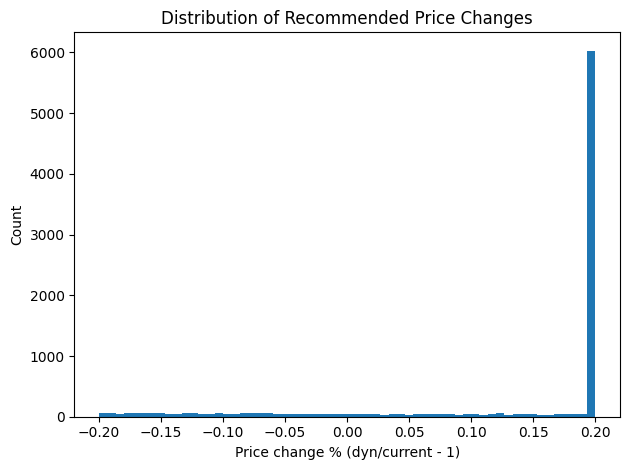

Saved plot: outputs_price_optimization/12_distribution_price_change_pct.png


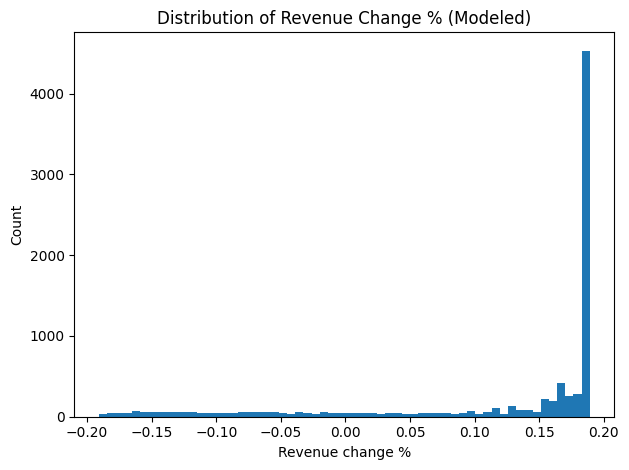

Saved plot: outputs_price_optimization/13_distribution_revenue_change_pct.png


In [21]:
# Post-pricing charts
plt.figure()
plt.hist(result["price_change_pct"], bins=60)
plt.title("Distribution of Recommended Price Changes")
plt.xlabel("Price change % (dyn/current - 1)")
plt.ylabel("Count")
savefig("12_distribution_price_change_pct.png")

plt.figure()
plt.hist(result["rev_change_pct"].replace([np.inf, -np.inf], np.nan).dropna(), bins=60)
plt.title("Distribution of Revenue Change % (Modeled)")
plt.xlabel("Revenue change %")
plt.ylabel("Count")
savefig("13_distribution_revenue_change_pct.png")

/tmp/ipython-input-334082878.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  result.groupby("price_tier", as_index=False)


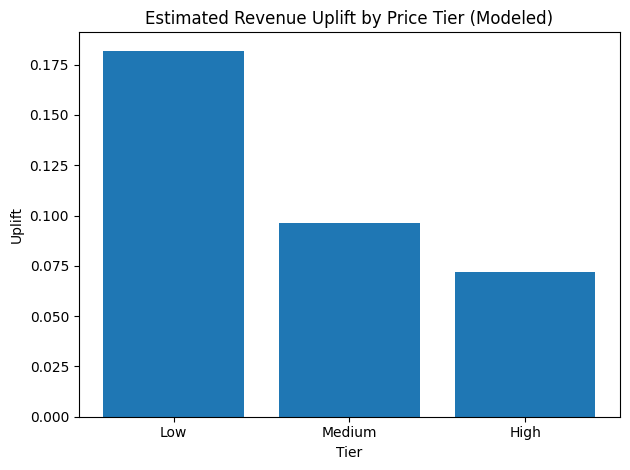

Saved plot: outputs_price_optimization/14_uplift_by_tier.png


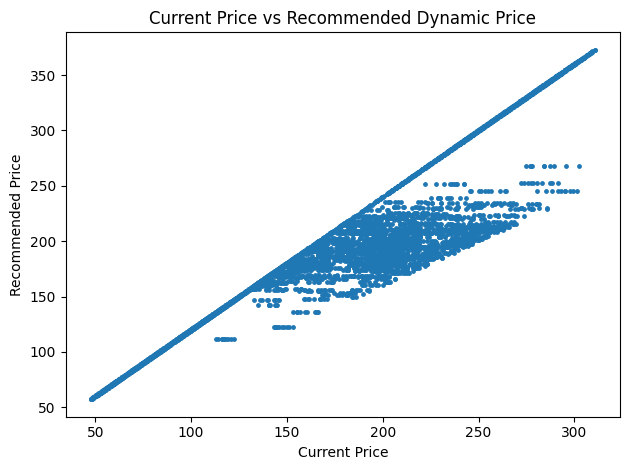

Saved plot: outputs_price_optimization/15_current_vs_recommended_price.png


In [22]:
tier_uplift = (
    result.groupby("price_tier", as_index=False)
          .agg(
              base_rev=("base_revenue", "sum"),
              dyn_rev=("dyn_revenue", "sum"),
              avg_price_change=("price_change_pct", "mean"),
              avg_qty_change=("qty_change_pct", "mean"),
              n=("Item_ID", "size"),
          )
)
tier_uplift["uplift_pct"] = (tier_uplift["dyn_rev"] / tier_uplift["base_rev"]) - 1
tier_uplift.to_csv(os.path.join(OUT_DIR, "tier_uplift_summary.csv"), index=False)

plt.figure()
plt.bar(tier_uplift["price_tier"].astype(str), tier_uplift["uplift_pct"])
plt.title("Estimated Revenue Uplift by Price Tier (Modeled)")
plt.xlabel("Tier")
plt.ylabel("Uplift")
savefig("14_uplift_by_tier.png")

plt.figure()
plt.scatter(result["Price"], result["dyn_price"], s=6)
plt.title("Current Price vs Recommended Dynamic Price")
plt.xlabel("Current Price")
plt.ylabel("Recommended Price")
savefig("15_current_vs_recommended_price.png")

1. Distribution of Recommended Price Changes (12_distribution_price_change_pct.png) This histogram displays the percentage change between the original price and the newly recommended dynamic price for all items.

Interpretation: It shows how much the prices are typically adjusted. For example, if the distribution is centered around 0%, it means most prices are not changing much. If it's skewed to the right (positive values), many prices are recommended to increase, and if skewed to the left (negative values), many are recommended to decrease. The spread indicates the variability in the recommended adjustments.

2. Distribution of Revenue Change % (Modeled) (13_distribution_revenue_change_pct.png) This histogram illustrates the percentage change in revenue for each item as a result of applying the dynamic pricing model.

Interpretation: This chart directly visualizes the estimated impact of the dynamic pricing strategy on individual item revenues. Positive values indicate an increase in modeled revenue, while negative values indicate a decrease. A distribution heavily skewed towards positive changes suggests a successful optimization strategy.

3. Estimated Revenue Uplift by Price Tier (Modeled) (14_uplift_by_tier.png) This bar chart shows the estimated revenue uplift (in percentage) for items grouped by their price tier (Low, Medium, High).

Interpretation: This helps to identify which price segments (e.g., lower-priced products, mid-range products, or high-end products) are projected to benefit most from the dynamic pricing strategy. Different tiers might show varying uplift percentages, guiding more targeted pricing efforts.

4. Current Price vs Recommended Dynamic Price (15_current_vs_recommended_price.png) This scatter plot compares the original current price of each item against its newly recommended dynamic price.

Interpretation: This visualization allows you to see the relationship between current and recommended prices. Points above the diagonal line (y=x) indicate a recommended price increase, while points below suggest a decrease. It can help identify patterns in pricing adjustments, such as whether higher-priced items are consistently recommended for increases or decreases, or if there's a specific price range where adjustments are more aggressive.


**Strategy Improvement**

In [23]:
def pct(x):
    return f"{x*100:.1f}%"

avg_gap = float(result["comp_gap_pct"].mean())
median_gap = float(result["comp_gap_pct"].median())
print(f"- On average, our prices are {pct(avg_gap)} {'below' if avg_gap < 0 else 'above'} competitor prices "
      f"(median: {pct(median_gap)}).")

mean_elast = float(result["elasticity"].mean())
med_elast = float(result["elasticity"].median())
print(f"- Estimated demand sensitivity is typically negative (avg: {mean_elast:.2f}, median: {med_elast:.2f}).")

print(f"- Under this demand-aware model, estimated total revenue changes by {pct(uplift)} "
      f"(model-based, not guaranteed).")

if len(tier_uplift) > 0:
    best_tier = tier_uplift.sort_values("uplift_pct", ascending=False).iloc[0]
    worst_tier = tier_uplift.sort_values("uplift_pct", ascending=True).iloc[0]
    print(f"- Best tier uplift: {best_tier['price_tier']} ({pct(float(best_tier['uplift_pct']))}).")
    print(f"- Lowest tier uplift: {worst_tier['price_tier']} ({pct(float(worst_tier['uplift_pct']))}).")

# Low-risk experiments list (item-level)
# Group the results by Item_ID to summarize key metrics for each item.
item_plan = (
    result.groupby("Item_ID", as_index=False)
    .agg(
        current_price=("Price", "mean"), # Average current price for the item
        rec_price=("dyn_price", "mean"), # Average recommended dynamic price for the item
        price_change=("price_change_pct", "mean"), # Average percentage price change
        base_rev=("base_revenue", "sum"), # Total base revenue for the item
        dyn_rev=("dyn_revenue", "sum"), # Total dynamic revenue for the item
        elasticity=("elasticity", "median"), # Median elasticity for the item
        comp_gap=("comp_gap_pct", "mean"), # Average competitor price gap
        n_obs=("Item_ID", "size"), # Number of observations for the item
    )
)
# Calculate the uplift percentage for each item.
item_plan["uplift_pct"] = (item_plan["dyn_rev"] / item_plan["base_rev"]) - 1

# Filter for low-risk candidates based on specified criteria:
# - Minimum number of observations (>=10) for reliable data.
# - Absolute price change within a small threshold (<=5%) to minimize risk.
# - Elasticity within a reasonable negative range (between -0.1 and -3.0) for predictable demand response.
low_risk = item_plan[
    (item_plan["n_obs"] >= 10) &
    (item_plan["price_change"].abs() <= 0.05) &
    (item_plan["elasticity"] <= -0.1) & (item_plan["elasticity"] >= -3.0)
].copy()

# Select the top 15 low-risk candidates by modeled uplift.
low_risk_top = low_risk.sort_values("uplift_pct", ascending=False).head(15)

print("\n" + "="*60)
print("LOW-RISK PRICE TEST CANDIDATES (Top 15 by modeled uplift)")
print("="*60)

if len(low_risk_top) == 0:
    print("No low-risk candidates found under current filters. Consider relaxing thresholds.")
else:
    # Define columns to display for the low-risk candidates.
    cols = ["Item_ID", "current_price", "rec_price", "price_change", "uplift_pct", "elasticity", "comp_gap", "n_obs"]
    # Print the top low-risk candidates with formatted output.
    print(low_risk_top[cols].to_string(index=False, formatters={
        "price_change": lambda x: f"{x*100:.1f}%",
        "uplift_pct": lambda x: f"{x*100:.1f}%",
        "comp_gap": lambda x: f"{x*100:.1f}%",
        "current_price": lambda x: f"{x:.2f}",
        "rec_price": lambda x: f"{x:.2f}",
        "elasticity": lambda x: f"{x:.2f}",
    }))
    # Save the low-risk candidates to a CSV file.
    low_risk_top.to_csv(os.path.join(OUT_DIR, "low_risk_price_test_candidates.csv"), index=False)
    print("\nSaved:", os.path.join(OUT_DIR, "low_risk_price_test_candidates.csv"))

print("\nDone. Stage 2 outputs written to:", OUT_DIR)

- On average, our prices are -2.5% below competitor prices (median: -7.1%).
- Estimated demand sensitivity is typically negative (avg: -0.09, median: -0.05).
- Under this demand-aware model, estimated total revenue changes by 10.1% (model-based, not guaranteed).
- Best tier uplift: Low (18.2%).
- Lowest tier uplift: High (7.2%).

LOW-RISK PRICE TEST CANDIDATES (Top 15 by modeled uplift)
 Item_ID current_price rec_price price_change uplift_pct elasticity comp_gap  n_obs
item_444        250.44    262.43         4.7%       3.9%      -0.14    39.5%     50
item_590        174.36    180.38         3.6%       2.6%      -0.23     7.4%     50
item_915        264.70    273.30         3.1%       2.2%      -0.20    44.8%     50
item_727        258.04    262.90         1.7%       1.4%      -0.15    34.9%     50
 item_41        183.08    185.73         1.5%       1.3%      -0.12     9.1%     50
item_947        225.30    228.89         1.5%       1.2%      -0.18    37.2%     50
item_410        232.20

### **Conclusion**

This project builds a two-stage, data-driven dynamic pricing approach that combines competitor price analysis with demand elasticity modelling to create realistic and actionable price recommendations.
The goal is to show how pricing can move from fixed rules toward evidence-based optimisation that improves revenue while staying practical for real business use.



Key Insights:

- Competitive positioning

  - The analysis shows that current prices are usually similar to or lower than competitor prices, suggesting a strong competitive position but also some room for selective price increases.
  - Stage 1 scenario testing highlights the possible revenue gain from pricing closer to competitors, while noting the simplifying assumption that demand stays constant.

- Demand sensitivity (elasticity)

  - Overall demand appears fairly insensitive to small price changes, meaning moderate adjustments are unlikely to cause large drops in quantity.
  - A log–log regression with item, store, and time effects provides more reliable elasticity estimates and shows that different price tiers behave differently, so pricing should vary by segment rather than follow a single rule.
  - Elasticity limits are applied to keep recommendations realistic and stable.

- Dynamic pricing potential

  - When demand response is included (Stage 2), the model shows clear revenue improvement compared with static pricing.
  - Recommended price changes include both increases and decreases, all kept within practical guardrails to reduce business risk.

#### **Business Impact and Value:**

- Higher revenue potential through demand-aware pricing.

- Clear, data-driven pricing decisions instead of intuition-based rules.

- Better response to competition and customer behaviour.

- Lower risk, because price changes are limited by realistic guardrails.

#### **Improvements:**

- Pilot testing: Run controlled A/B tests on low-risk items to confirm real-world impact.

- Continuous updates: Retrain elasticity models regularly as new data arrives.

- More demand drivers: Add promotions, seasonality, product features, customer behaviour, and inventory data to improve accuracy.

- Different optimisation goals: Extend beyond revenue to include profit, market share, or inventory efficiency, depending on business needs.